In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 13.8 MB/s eta 0:00:00


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.8 MB/s eta 0:00:00


In [4]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import shap

In [5]:
movies_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/movies_metadata.csv")
users_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/user_metadata.csv")
rating = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/ratings.csv")
rating = rating.sample(frac=1)

In [6]:
train_user = np.load('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/train_user.npy')
valid_user = np.load('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/valid_user.npy')
test_user = np.load('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/test_user.npy')

In [7]:
train_negative = rating[rating['userId'].isin(train_user)]
valid_negative = rating[rating['userId'].isin(valid_user)]
test_negative = rating[rating['userId'].isin(test_user)]

In [8]:
train_negative = train_negative.sample(frac=0.5)

In [9]:
train_negative[['userId', 'movieId']] = train_negative[['userId', 'movieId']].astype(str)
valid_negative[['userId', 'movieId']] = valid_negative[['userId', 'movieId']].astype(str)
test_negative[['userId', 'movieId']] = test_negative[['userId', 'movieId']].astype(str)
movies_metadata['id'] = movies_metadata['id'].astype(str)
users_metadata['userId'] = users_metadata['userId'].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
train_negative = train_negative.merge(users_metadata, on='userId').merge(movies_metadata, left_on='movieId', right_on='id')
valid_negative = valid_negative.merge(users_metadata, on='userId').merge(movies_metadata, left_on='movieId', right_on='id')
test_negative = test_negative.merge(users_metadata, on='userId').merge(movies_metadata, left_on='movieId', right_on='id')
train_negative.head(3)

,userId,movieId,rating,timestamp,total_movies,userAvgRating,userAvgBudget,userTopLanguages,userTopGenres,userTopPH,...,production_companies,production_countries,revenue,runtime,spoken_languages,video,vote_average,vote_count,movie_age,abstract_col
0,53870,435,3.0,836560409,36,4.0,3750000.0,en,Comedy,Universal Pictures,...,Lions Gate Films,United States of America,544272402,124,English,False,6.2,2462.0,6914.0,action adventure science fiction thriller lion...
1,16424,435,2.0,839254188,45,4.0,3000000.0,en,Comedy,Universal Pictures,...,Lions Gate Films,United States of America,544272402,124,English,False,6.2,2462.0,6914.0,action adventure science fiction thriller lion...
2,22639,435,2.0,835788862,135,4.0,2888030.0,en,Comedy,Paramount Pictures,...,Lions Gate Films,United States of America,544272402,124,English,False,6.2,2462.0,6914.0,action adventure science fiction thriller lion...


In [11]:
train_negative.loc[train_negative['rating'] >= train_negative['userAvgRating'], 'label'] = 1
train_negative.loc[train_negative['rating'] < train_negative['userAvgRating'], 'label'] = 0

In [12]:
valid_negative.loc[valid_negative['rating'] >= valid_negative['userAvgRating'], 'label'] = 1
valid_negative.loc[valid_negative['rating'] < valid_negative['userAvgRating'], 'label'] = 0

In [14]:
train_negative.to_csv('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/train_negative.csv')

In [ ]:
col_list = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'movie_age', 'production_companies', 'production_countries', 'spoken_languages', 'genres', 'total_movies', 'userAvgRating', 'userAvgBudget', 'userAvgPopularity', 
                            'userAvgMovieAge', 'userAvgRuntime', 'userTopPH', 'userTopGenres']
categorical_col = ['production_companies', 'production_countries', 'spoken_languages', 'genres', 'userTopPH', 'userTopGenres']

train_negative[categorical_col] = train_negative[categorical_col].fillna('other')
train_negative[col_list] = train_negative[col_list].fillna(-1)
 
valid_negative[categorical_col] = valid_negative[categorical_col].fillna('other')
valid_negative[col_list] = valid_negative[col_list].fillna(-1)

test_negative[categorical_col] = test_negative[categorical_col].fillna('other')
test_negative[col_list] = test_negative[col_list].fillna(-1)

In [ ]:
model_params = {
    'iterations': 10, 
    'loss_function': 'Logloss',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 42,
}

X_train_custom = train_negative[col_list]
X_test_custom = valid_negative[col_list]
y_train = train_negative['label']
y_test = valid_negative['label']

train_dataset = Pool(X_train_custom, y_train, feature_names=col_list, cat_features=categorical_col) 
test_dataset = Pool(X_test_custom, y_test, feature_names=col_list, cat_features=categorical_col)

In [ ]:
model = CatBoostClassifier(loss_function='CrossEntropy')
grid = {'iterations': [200],
        'learning_rate': [0.1],
        'depth': [8],
        'l2_leaf_reg': [0.2]}
model.grid_search(grid, train_dataset, plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6806610	test: 0.6803504	best: 0.6803504 (0)	total: 806ms	remaining: 2m 40s
1:	learn: 0.6684161	test: 0.6676907	best: 0.6676907 (1)	total: 1.34s	remaining: 2m 12s
2:	learn: 0.6584326	test: 0.6574005	best: 0.6574005 (2)	total: 1.83s	remaining: 2m
3:	learn: 0.6507850	test: 0.6494066	best: 0.6494066 (3)	total: 2.28s	remaining: 1m 51s
4:	learn: 0.6445918	test: 0.6429658	best: 0.6429658 (4)	total: 3.23s	remaining: 2m 5s
5:	learn: 0.6391655	test: 0.6372838	best: 0.6372838 (5)	total: 4.19s	remaining: 2m 15s
6:	learn: 0.6349510	test: 0.6329403	best: 0.6329403 (6)	total: 5.07s	remaining: 2m 19s
7:	learn: 0.6313216	test: 0.6291143	best: 0.6291143 (7)	total: 6.07s	remaining: 2m 25s
8:	learn: 0.6282735	test: 0.6258837	best: 0.6258837 (8)	total: 6.88s	remaining: 2m 26s
9:	learn: 0.6256236	test: 0.6230586	best: 0.6230586 (9)	total: 7.5s	remaining: 2m 22s
10:	learn: 0.6237015	test: 0.6209462	best: 0.6209462 (10)	total: 7.93s	remaining: 2m 16s
11:	learn: 0.6221384	test: 0.6192517	best: 0.61

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
model.fit(train_dataset, verbose=True, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6802276	total: 1.26s	remaining: 4m 10s
1:	learn: 0.6677184	total: 1.95s	remaining: 3m 13s
2:	learn: 0.6580542	total: 2.45s	remaining: 2m 40s
3:	learn: 0.6500233	total: 3.05s	remaining: 2m 29s
4:	learn: 0.6433708	total: 3.6s	remaining: 2m 20s
5:	learn: 0.6382238	total: 4.01s	remaining: 2m 9s
6:	learn: 0.6338603	total: 4.63s	remaining: 2m 7s
7:	learn: 0.6305978	total: 5.36s	remaining: 2m 8s
8:	learn: 0.6279179	total: 5.92s	remaining: 2m 5s
9:	learn: 0.6256495	total: 6.58s	remaining: 2m 5s
10:	learn: 0.6238163	total: 7.05s	remaining: 2m 1s
11:	learn: 0.6219784	total: 7.82s	remaining: 2m 2s
12:	learn: 0.6204221	total: 8.44s	remaining: 2m 1s
13:	learn: 0.6192259	total: 9.08s	remaining: 2m
14:	learn: 0.6181516	total: 9.73s	remaining: 2m
15:	learn: 0.6171374	total: 10.5s	remaining: 2m 1s
16:	learn: 0.6162827	total: 11.3s	remaining: 2m 1s
17:	learn: 0.6153732	total: 12.7s	remaining: 2m 7s
18:	learn: 0.6147086	total: 13.9s	remaining: 2m 12s
19:	learn: 0.6138994	total: 15s	remaining:

In [ ]:
pred = model.predict_proba(test_negative[col_list])

In [ ]:
test_negative.loc[test_negative['rating'] >= test_negative['userAvgRating'], 'label'] = 1
test_negative.loc[test_negative['rating'] < test_negative['userAvgRating'], 'label'] = 0

In [ ]:
df = test_negative[['userId', 'movieId', 'rating', 'label']]

In [ ]:
df['prediction_score'] = pred[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df.sort_values(['userId', 'prediction_score'], inplace=True, ascending=False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
result = df.groupby('userId').agg(movies=('movieId', list), label=('label', list), rating=('rating', list), pred=('prediction_score', list))

<Axes: ylabel='Frequency'>

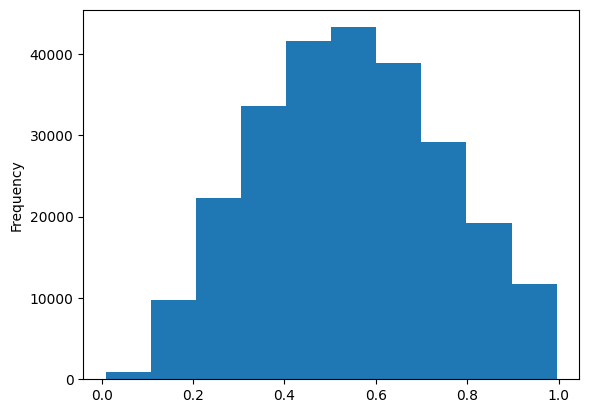

In [ ]:
df['prediction_score'].plot.hist()

In [ ]:
np.where(np.array([0,0,1]) > 0)

(array([2]),)

In [ ]:
result['MRR'] = result['label'].apply(lambda x: 1/(np.where(np.array(x)>0)[0][0]+1))

In [ ]:
result

,movies,label,rating,pred,MRR
userId,,,,,
10019,"[318, 111, 296, 116, 161, 58, 319, 110, 17, 26...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[3.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 3.0, 4.0, ...","[0.8955803106878543, 0.8508975988560677, 0.839...",0.500000
10064,"[858, 912, 3022, 922, 923, 3114, 2019, 1248, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, ...","[0.7653377688099221, 0.7489098056760144, 0.736...",1.000000
10066,"[318, 527, 58559, 3578, 2028, 1259, 593, 110, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.5, 4.0, ...","[0.6853959341351271, 0.6261180853160038, 0.606...",1.000000
10080,"[318, 296, 260, 858, 527, 608, 541, 4011, 593,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ...","[0.8745661231668957, 0.8360488225071451, 0.826...",1.000000
10083,"[858, 527, 593, 912, 260, 296, 898, 2731, 1252...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 3.0, ...","[0.8421831516232199, 0.8274092068523083, 0.809...",1.000000
...,...,...,...,...,...
9944,"[318, 1213, 296, 111, 1089, 293, 163, 1639, 22...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[4.0, 5.0, 5.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, ...","[0.920013255324777, 0.8585311724817298, 0.8401...",1.000000
9976,"[318, 296, 457, 593, 161, 300, 110, 349, 480, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 4.0, ...","[0.8892739263239534, 0.8490575927137469, 0.793...",1.000000
9984,"[318, 58559, 1252, 527, 858, 745, 916, 2959, 9...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[2.5, 3.0, 4.0, 3.5, 3.5, 5.0, 4.5, 2.0, 5.0, ...","[0.7963911116039077, 0.7172335625085794, 0.697...",0.166667


In [ ]:
result['MRR'].describe()

count    4802.000000
mean        0.911406
std         0.208194
min         0.083333
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: MRR, dtype: float64

<Axes: ylabel='Frequency'>

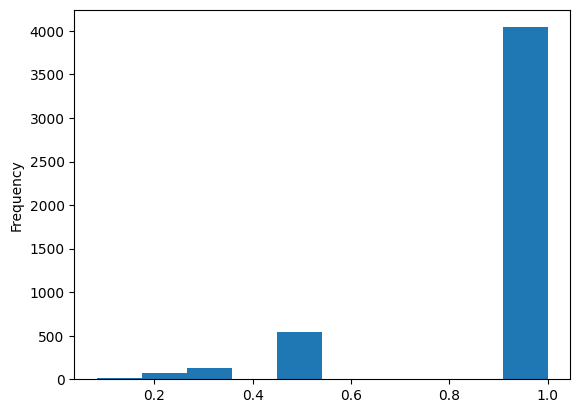

In [ ]:
result['MRR'].plot.hist()

In [ ]:
result.to_csv('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/HR_result.csv', index=True)

In [ ]:
model.save_model('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/Catboost',           
           format="cbm",
           export_parameters=None,
           pool=None)

# Model Analysis

In [ ]:
shap.initjs()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


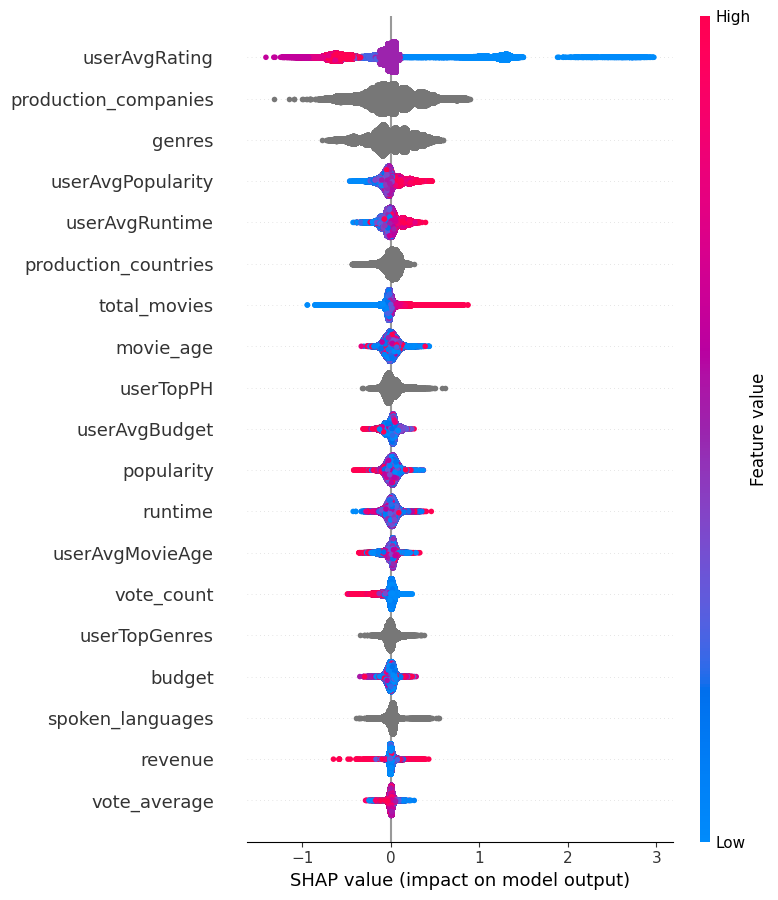

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_negative[col_list])
shap.summary_plot(shap_values, test_negative[col_list], feature_names = col_list)

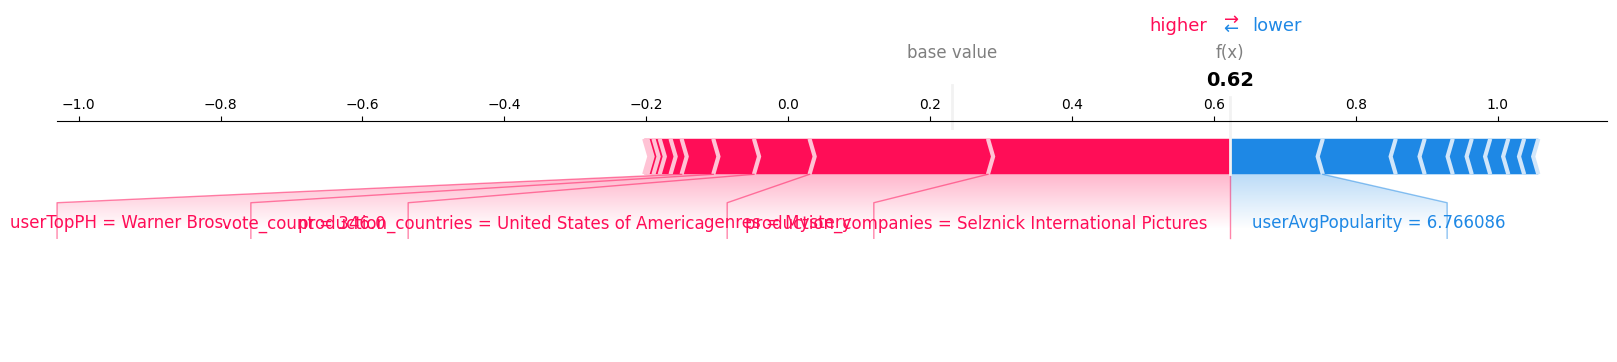

In [ ]:
id = 0

shap.force_plot(explainer.expected_value, shap_values[id,:], test_negative[col_list].iloc[id,:], matplotlib=True)